In [6]:
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import pandas as pd

In [7]:
fig_dir = Path.home() / "dev/data/exp/follow/figures"
fig_dir.mkdir(parents=True, exist_ok=True)

lacam_init_dir = Path.home() / "dev/data/exp/follow/2024-11-17T21-23-48.366"
lacam_no_following_dir = Path.home() / "dev/data/exp/follow/2024-11-17T22-52-35.961"

In [8]:
def read_yaml(file_path):
    with open(file_path, mode="r") as file:
        data = yaml.safe_load(file)
    return data

In [9]:
init_config = read_yaml(lacam_init_dir / "config.yaml")
no_follow_config = read_yaml(lacam_no_following_dir / "config.yaml")
assert init_config["maps"] == no_follow_config["maps"]
map_names = [f'{x}.map' for x in init_config["maps"]]

lacam_df = pd.read_csv(lacam_init_dir / "result.csv")
lacam_no_following_df = pd.read_csv(lacam_no_following_dir / "result.csv")

df = pd.concat([lacam_df, lacam_no_following_df], ignore_index=True)

empty-16-16.map


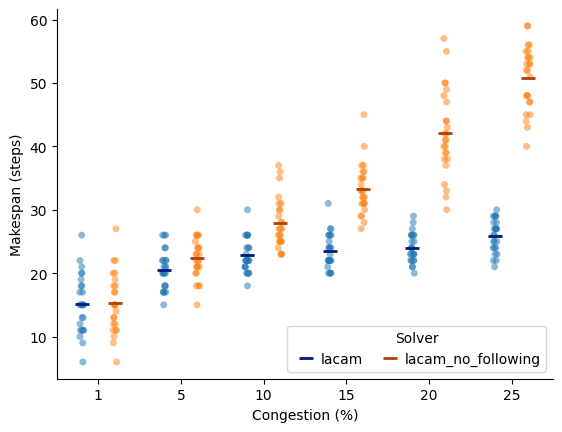

In [14]:
for map_name in map_names[:1]:
    f, ax = plt.subplots()
    print(map_name)
    filtered_df = df[df['map_name'] == map_name]
    filtered_df = filtered_df.assign(congestion=(100 * filtered_df['num_agents'] / filtered_df['num_open_vertices']).round(0).astype(int))

    melted = filtered_df.melt(id_vars=['congestion', 'solver'], var_name='measurement', value_vars=['makespan'])
    sns.despine(left=False, bottom=False)
    ax = sns.stripplot(data=melted, x='congestion', y='value', hue='solver', dodge=True, alpha=0.5, jitter=0.05, ax=ax, legend=False, zorder=1)

    sns.pointplot(
        data=melted,
        x="congestion",
        y="value",
        hue="solver",
        dodge=0.8 - 0.8 / 2,
        palette="dark",
        errorbar=None,
        markers="_",
        markersize=10,
        linestyle="none",
    )

    sns.move_legend(
        ax,
        loc="lower right",
        ncol=3,
        frameon=True,
        columnspacing=1,
        handletextpad=0,
    )

    ax.set_xlabel("Congestion (%)")
    ax.set_ylabel("Makespan (steps)")
    ax.get_legend().set_title('Solver')

    plt.show()